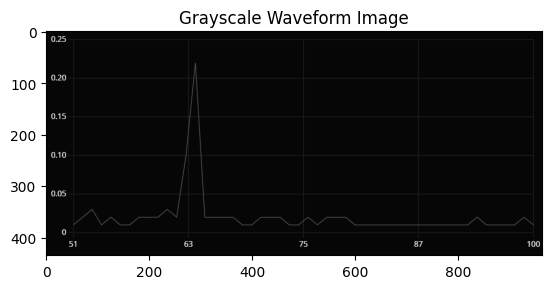

Jitter (%): 0.008159589291897574
Jitter (RAP): 0.001100401466970021
Jitter (PPQ5): 0.002890195842081984
Jitter (DDP): 0.0016133771862439936


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/Screenshot 2024-07-19 111906.png'  # Change the path to the correct image file
image = Image.open(image_path)

# Convert image to numpy array
image_data = np.array(image)

# Convert the image to grayscale (for easier processing, if needed)
gray_image = np.mean(image_data[:, :, :3], axis=2)

# Convert the image to grayscale (for easier processing, if needed)
gray_image = np.mean(image_data[:, :, :3], axis=2)

# Display the grayscale image
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Waveform Image')
plt.show()

# Apply a threshold to isolate the waveform line
threshold = 100  # Adjust based on the image
binary_image = gray_image < threshold

# Get the height and width of the image
height, width = binary_image.shape

# Initialize arrays to store feature values
jitter_percentages = []

# Extract the y-coordinates of the waveform line for each x-coordinate
for x in range(width):
    y_coords = np.where(binary_image[:, x])[0]
    if len(y_coords) > 1:
        # Compute jitter (local) - standard deviation of y-coordinates
        jitter_local = np.std(np.diff(y_coords))
        jitter_percentages.append(jitter_local / height)  # Store jitter as a percentage of image height


# Calculate mean jitter and shimmer across all x-coordinates
mean_jitter_percentage = np.mean(jitter_percentages) * 100

# Extract the y-coordinates of the waveform line for each x-coordinate
y_coords = []
for x in range(width):
    y = np.where(binary_image[:, x])[0]
    if len(y) > 0:
        y_coords.append(np.mean(y))

y_coords = np.array(y_coords)

# Print extracted features
print(f"Jitter (%): {mean_jitter_percentage}")

# Jitter (RAP)
jitter_rap = np.mean(np.abs(np.diff(y_coords, n=2)) / y_coords[1:-1])
print(f"Jitter (RAP): {jitter_rap}")

# Jitter (PPQ5)
jitter_ppq5 = np.mean(np.abs(np.diff(y_coords, n=4)) / y_coords[2:-2])
print(f"Jitter (PPQ5): {jitter_ppq5}")

# Jitter (DDP)
jitter_ddp = np.mean(np.abs(np.diff(y_coords, n=3)) / y_coords[1:-2])
print(f"Jitter (DDP): {jitter_ddp}")

In [ ]:
waveform = (image_data[height//2, :] / 255.0) * 2 - 1  # Normalize to -1 to 1
import librosa
import librosa.display
# Step 3: Assume a sample rate
sample_rate = 22050  # This may need adjustment based on your specific data

# Step 4: Calculate features using librosa and other methods where necessary

# Shimmer calculation
def calculate_shimmer(waveform):
    shimmer = np.std(np.abs(waveform))
    shimmer_apq3 = np.mean(np.abs(waveform[3:] - waveform[:-3]))
    shimmer_apq5 = np.mean(np.abs(waveform[5:] - waveform[:-5]))
    shimmer_apq11 = np.mean(np.abs(waveform[11:] - waveform[:-11]))
    shimmer_dda = np.mean(np.abs(waveform[2:] - waveform[:-2]))
    return shimmer, shimmer_apq3, shimmer_apq5, shimmer_apq11, shimmer_dda


# Calculate shimmer
shimmer, shimmer_apq3, shimmer_apq5, shimmer_apq11, shimmer_dda = calculate_shimmer(waveform)

# Print extracted features
print("Extracted features:")
print(f"Shimmer: {shimmer}")
print(f"Shimmer:APQ3: {shimmer_apq3}")
print(f"Shimmer:APQ5: {shimmer_apq5}")
print(f"Shimmer:APQ11: {shimmer_apq11}")
print(f"Shimmer:DDA: {shimmer_dda}")

Extracted features:
Shimmer: 0.1054401581526101
Shimmer:APQ3: 0.0041949766378976145
Shimmer:APQ5: 0.00426506368970946
Shimmer:APQ11: 0.004291916136863979
Shimmer:DDA: 0.003994945171415759


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import librosa
import librosa.display
from scipy.stats import entropy

image = Image.open(image_path).convert('L')  # Convert to grayscale
image_data = np.array(image)

# Step 2: Convert Image to Waveform
# Assuming the waveform is represented as a plot from -1 to 1 on the y-axis and time on the x-axis
height, width = image_data.shape
waveform = (image_data[height//2, :] / 255.0)

# Normalize the waveform
waveform = waveform - np.mean(waveform)
waveform = waveform / np.max(np.abs(waveform))

# Sample rate assumption
sample_rate = 22050  # Adjust based on your data

# DFA Calculation
def calculate_dfa(waveform):
    def dfa(y):
        N = len(y)
        nvals = np.logspace(0.5, np.log10(N // 2), num=20).astype(int)
        F = np.zeros(len(nvals))

        for i, n in enumerate(nvals):
            n_segments = N // n
            X = np.tile(np.arange(n), (n_segments, 1))
            Y = y[:n * n_segments].reshape((n_segments, n))
            Y_cumsum = np.cumsum(Y - np.mean(Y, axis=1)[:, None], axis=1)
            Y_fit = np.array([np.polyfit(X[j], Y_cumsum[j], 1)[0] * X[j] + np.polyfit(X[j], Y_cumsum[j], 1)[1] for j in range(n_segments)])
            F[i] = np.sqrt(np.mean((Y_cumsum - Y_fit) ** 2))

        # Fit a line to log-log plot
        p = np.polyfit(np.log(nvals), np.log(F), 1)
        return p[0]

    return dfa(waveform)

# Calculate DFA
dfa = calculate_dfa(waveform)

# Print extracted features
print("Extracted features:")
print(f"DFA: {dfa}")

Extracted features:
DFA: 0.6460460703851642


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Get the height and width of the image
height, width = image_data.shape

# Apply a threshold to isolate the waveform line
threshold = 100  # Adjust based on the image
binary_image = image_data < threshold

# Extract the waveform from the image (assuming the waveform is represented along the middle row)
waveform = (image_data[height // 2, :] / 255.0) * 2 - 1  # Normalize to -1 to 1

# Normalize the waveform
waveform = waveform - np.mean(waveform)
waveform = waveform / np.max(np.abs(waveform))

In [ ]:
import numpy as np

# Shimmer in dB calculation
def calculate_shimmer_db(waveform):
    N = len(waveform)
    shimmer_db_values = []
    for i in range(N - 1):
        A_i = np.abs(waveform[i])
        A_i1 = np.abs(waveform[i + 1])
        if A_i > 0 and A_i1 > 0:  # To avoid log of zero
            shimmer_db_value = np.abs(20 * np.log10(A_i1 / A_i))
            shimmer_db_values.append(shimmer_db_value)
    shimmer_db = np.mean(shimmer_db_values)
    return shimmer_db

# Calculate shimmer in dB
shimmer_db = calculate_shimmer_db(waveform)

# Print extracted feature
print(f"Shimmer in dB: {shimmer_db}")

Shimmer in dB: 0.5034370269264304


In [ ]:
from scipy.signal import find_peaks
def calculate_jitter_abs(waveform, sample_rate):
    # Normalize the waveform
    waveform = waveform - np.mean(waveform)
    waveform = waveform / np.max(np.abs(waveform))

    # Detect peaks in the waveform
    peaks, _ = find_peaks(waveform, height=0)

    # Calculate the periods between consecutive peaks
    periods = np.diff(peaks) / sample_rate  # Periods in seconds

    # Compute the absolute differences between consecutive periods
    absolute_differences = np.abs(np.diff(periods))

    # Compute the average of these absolute differences
    jitter_abs = np.mean(absolute_differences)

    return jitter_abs

# Example usage:
# Load your waveform data
# Here, we simulate a waveform for demonstration purposes.
sample_rate = 22050

# Calculate Jitter(Abs)
jitter_abs = calculate_jitter_abs(waveform, sample_rate)

print(f"Jitter(Abs): {jitter_abs}")

Jitter(Abs): 0.003999999999999999


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.stats import entropy
from PIL import Image

# Extract waveform from the image
height, width = image_data.shape
waveform = (image_data[height//2, :] / 255.0) * 2 - 1  # Normalize to -1 to 1

# Sample rate assumption
sample_rate = 22050  # Adjust based on your data

# Function to embed the time series in phase space
def embed_time_series(signal, tau, dimension):
    N = len(signal)
    if N < (dimension - 1) * tau:
        raise ValueError("Signal is too short for given embedding parameters.")
    embedded = np.array([signal[i: i + (dimension - 1) * tau + 1: tau] for i in range(N - (dimension - 1) * tau)])
    return embedded

# RPDE Calculation
def calculate_rpde(signal, tau=1, dimension=3):
    embedded = embed_time_series(signal, tau, dimension)
    T_values = []
    for i, point in enumerate(embedded):
        distances = np.linalg.norm(embedded - point, axis=1)
        neighborhood = np.where((distances > 0) & (distances < np.mean(distances)))[0]
        if len(neighborhood) > 1:
            T = np.diff(neighborhood)
            T_values.extend(T)
    T_max = 1000
    hist, bin_edges = np.histogram(T_values, bins=T_max, range=(1, T_max), density=True)
    P_T = hist / np.sum(hist)
    RPDE_value = -np.sum(P_T * np.log(P_T + 1e-10)) / np.log(T_max)
    return RPDE_value


# Calculate the features
rpde = calculate_rpde(waveform)

# Print extracted features
print(f"RPDE: {rpde}")

RPDE: 0.010330851769589292


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import find_peaks
from scipy.stats import entropy

# Extract the y-coordinates of the waveform line for each x-coordinate
y_coords = []
for x in range(width):
    y = np.where(binary_image[:, x])[0]
    if len(y) > 0:
        y_coords.append(np.mean(y))

y_coords = np.array(y_coords)

# Normalize the waveform
waveform = y_coords - np.mean(y_coords)
waveform = waveform / np.max(np.abs(waveform))

# Sample rate assumption
sample_rate = 22050  # Adjust based on your data

# Function to calculate Pitch Period Entropy (PPE)
def calculate_ppe(waveform, sample_rate):
    peaks, _ = find_peaks(waveform)
    periods = np.diff(peaks) / sample_rate
    hist, bin_edges = np.histogram(periods, bins='auto', density=True)
    ppe = entropy(hist)
    return ppe

# Calculate PPE
ppe = calculate_ppe(waveform, sample_rate)

# Print extracted features
print(f"Pitch Period Entropy (PPE): {ppe}")


Pitch Period Entropy (PPE): 0.6554817739013927


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Convert image to numpy array
image_data = np.array(image)

# Apply a threshold to isolate the waveform line
threshold = 100  # Adjust based on the image
binary_image = image_data < threshold

# Get the height and width of the image
height, width = binary_image.shape

# Extract the y-coordinates of the waveform line for each x-coordinate
y_coords = []
for x in range(width):
    y = np.where(binary_image[:, x])[0]
    if len(y) > 0:
        y_coords.append(np.mean(y))

# Normalize the waveform
waveform = np.array(y_coords)
waveform = waveform - np.mean(waveform)
waveform = waveform / np.max(np.abs(waveform))




In [ ]:
import scipy.signal
import scipy.fft

def calculate_hnr(waveform, sample_rate):
    # Perform a Fourier Transform on the waveform
    fft_spectrum = scipy.fft.fft(waveform)
    fft_freq = scipy.fft.fftfreq(len(waveform), 1 / sample_rate)

    # Identify harmonic frequencies (peaks in the FFT spectrum)
    peaks, _ = scipy.signal.find_peaks(np.abs(fft_spectrum), height=0)

    harmonic_power = np.sum(np.abs(fft_spectrum[peaks]) ** 2)
    total_power = np.sum(np.abs(fft_spectrum) ** 2)
    noise_power = total_power - harmonic_power

    hnr = 10 * np.log10(harmonic_power / noise_power)

    return hnr

# Sample rate assumption
sample_rate = 22050  # Adjust based on your specific data

# Calculate HNR and NHR
hnr = calculate_hnr(waveform, sample_rate)
nhr=1/hnr
print(f"Harmonic to Noise Ratio (HNR): {hnr}")
print(f"Noise to Harmonics Ratio (NHR): {1/hnr}")


Harmonic to Noise Ratio (HNR): 2.295550618327575
Noise to Harmonics Ratio (NHR): 0.4356253318990416


In [ ]:
subject=43
age=int(input("Enter the age: "))
sex=int(input("Whats the gender(0-Male,1-Female): "))
test_time=49
final_list=np.array([subject,age,sex,test_time,mean_jitter_percentage,jitter_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer ,shimmer_db,shimmer_apq3,shimmer_apq5,
            shimmer_apq11,shimmer_dda,nhr,hnr,rpde,dfa,ppe])
final_list

Enter the age: 78
Whats the gender(0-Male,1-Female): 0


array([4.30000000e+01, 7.80000000e+01, 0.00000000e+00, 4.90000000e+01,
       8.15958929e-03, 4.00000000e-03, 1.10040147e-03, 2.89019584e-03,
       1.61337719e-03, 1.05440158e-01, 5.03437027e-01, 4.19497664e-03,
       4.26506369e-03, 4.29191614e-03, 3.99494517e-03, 4.35625332e-01,
       2.29555062e+00, 1.03308518e-02, 6.46046070e-01, 6.55481774e-01])

In [ ]:
final_list.shape

(20,)

In [ ]:
print(cnn_model.input_shape)


(None, 20, 1)


In [ ]:
final_list_reshaped = final_list.reshape(1,20, 1)
print(final_list_reshaped)

[[[4.30000000e+01]
  [7.80000000e+01]
  [0.00000000e+00]
  [4.90000000e+01]
  [8.15958929e-03]
  [4.00000000e-03]
  [1.10040147e-03]
  [2.89019584e-03]
  [1.61337719e-03]
  [1.05440158e-01]
  [5.03437027e-01]
  [4.19497664e-03]
  [4.26506369e-03]
  [4.29191614e-03]
  [3.99494517e-03]
  [4.35625332e-01]
  [2.29555062e+00]
  [1.03308518e-02]
  [6.46046070e-01]
  [6.55481774e-01]]]


In [ ]:
final_list_reshaped.shape

(1, 20, 1)

In [ ]:
# Make predictions
prediction1 = cnn_model.predict(final_list_reshaped)
print(prediction1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[0. 0. 1. 0.]]


In [ ]:
motor_final_list = np.hstack((final_list, prediction1[0,0]))
total_final_list = np.hstack((final_list, prediction1[0,2]))

In [ ]:
motor_UPDRS_pred = lgb_motor_model.predict(motor_final_list.reshape(1,-1))
total_UPDRS_pred = lgb_total_model.predict(total_final_list.reshape(1,-1))
print(motor_UPDRS_pred)
print(total_UPDRS_pred)

[7.03477628]
[22.22218824]
